In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential, Input
from keras.layers import Dense
from keras.activations import relu, softmax
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy


In [5]:
df_submission = pd.read_csv('./playground-series-s4e2/sample_submission.csv')
df_train = pd.read_csv('./playground-series-s4e2/train.csv')
df_train_obesity_cvd=pd.read_csv('./archive/ObesityDataSet.csv')
df_test = pd.read_csv('./playground-series-s4e2/test.csv')

In [6]:
df_train.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [7]:
df_train = df_train.drop("id",axis=1)
df_test=df_test.drop("id",axis=1)
df_train.shape

(20758, 17)

In [8]:
# Concatinating training data from all sources
df_train = pd.concat([df_train, df_train_obesity_cvd])
df_train=df_train.drop_duplicates()

In [9]:
# Encoding categorical variables (one-hot encoding)

non_numerical_columns = ["Gender", "family_history_with_overweight",
                         "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]
encoded_df_train = pd.get_dummies(df_train, columns=non_numerical_columns)
encoded_df_test = pd.get_dummies(df_test, columns=non_numerical_columns)

encoded_df_train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


In [10]:
# Normalizing numerical features
numerical_columns = ["Age", "Height", "Weight",
                     "FCVC", "NCP", "CH2O", "FAF", "TUE"]
scaler = StandardScaler()
encoded_df_train[numerical_columns] = scaler.fit_transform(
    encoded_df_train[numerical_columns])
encoded_df_train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.096347,-0.005336,-0.232290,-0.831819,0.319839,1.210272,-1.172529,0.589741,Overweight_Level_II,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,-1.023162,-1.598693,-1.168077,-0.831819,0.343326,-0.044645,0.018358,0.628771,Normal_Weight,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False
2,-1.023162,0.125116,-1.427315,-1.055798,-1.890059,-0.191936,-0.141167,1.746217,Insufficient_Weight,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
3,-0.510107,0.116808,1.649336,1.043017,0.343326,-0.580319,0.575530,0.264131,Obesity_Type_III,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,1.347052,2.432398,0.227756,0.442440,-1.102923,-0.077764,1.171105,0.515499,Overweight_Level_II,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


In [11]:
label_encoder = LabelEncoder()


#  encoding NObeyesdad feature since it takes values of string type
encoded_df_train['NObeyesdad'] = label_encoder.fit_transform(
    encoded_df_train['NObeyesdad'])
encoded_df_train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.096347,-0.005336,-0.232290,-0.831819,0.319839,1.210272,-1.172529,0.589741,6,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,-1.023162,-1.598693,-1.168077,-0.831819,0.343326,-0.044645,0.018358,0.628771,1,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False
2,-1.023162,0.125116,-1.427315,-1.055798,-1.890059,-0.191936,-0.141167,1.746217,0,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
3,-0.510107,0.116808,1.649336,1.043017,0.343326,-0.580319,0.575530,0.264131,4,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,1.347052,2.432398,0.227756,0.442440,-1.102923,-0.077764,1.171105,0.515499,6,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


In [12]:
#  Fill missing values
encoded_df_train = encoded_df_train.fillna(encoded_df_train.mean())
encoded_df_train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.096347,-0.005336,-0.232290,-0.831819,0.319839,1.210272,-1.172529,0.589741,6,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,-1.023162,-1.598693,-1.168077,-0.831819,0.343326,-0.044645,0.018358,0.628771,1,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False
2,-1.023162,0.125116,-1.427315,-1.055798,-1.890059,-0.191936,-0.141167,1.746217,0,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,True,False
3,-0.510107,0.116808,1.649336,1.043017,0.343326,-0.580319,0.575530,0.264131,4,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False
4,1.347052,2.432398,0.227756,0.442440,-1.102923,-0.077764,1.171105,0.515499,6,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,True,False


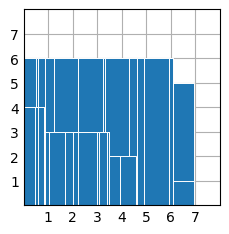

In [15]:
plt.style.use('_mpl-gallery')
fig,ax=plt.subplots()

ax.bar(encoded_df_train['Age'],encoded_df_train['NObeyesdad'],width=1,edgecolor='white',linewidth=0.7)

plt.show()

In [21]:
# Extracting (feature) X and (result) y variable from training set

X = encoded_df_train.drop('NObeyesdad', axis=1)
y = encoded_df_train['NObeyesdad']

In [22]:
X.shape, y.shape

((22845, 31), (22845,))

In [23]:
#  train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [24]:
# Transforming training and test data to numpy array
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

# X_train = X_train.fill(X_train.mean())
# X_test = X_test.fill(X_test.mean())

# Model Building

In [26]:
import keras

model = Sequential(
    [
        Input(X_train.shape[1],),
        Dense(25, activation=relu,kernel_regularizer= keras.regularizers.l2(0.02)),
        Dense(20, activation=relu, ),
        Dense(7, activation=softmax)
    ],
)

In [27]:
model.compile(optimizer=Adam(learning_rate=0.003), loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )

In [28]:

history = model.fit(X_train, y_train, epochs=32,
                    batch_size=5, validation_split=0.1)

Epoch 1/32


/home/dheeraj/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3290/3290 [==============================] - 11s 3ms/step - loss: 0.6383 - accuracy: 0.7651 - val_loss: 0.4098 - val_accuracy: 0.8463
Epoch 2/32
3290/3290 [==============================] - 9s 3ms/step - loss: 0.3908 - accuracy: 0.8606 - val_loss: 0.3615 - val_accuracy: 0.8802
Epoch 3/32
3290/3290 [==============================] - 10s 3ms/step - loss: 0.3754 - accuracy: 0.8689 - val_loss: 0.3501 - val_accuracy: 0.8758
Epoch 4/32
3290/3290 [==============================] - 9s 3ms/step - loss: 0.3671 - accuracy: 0.8745 - val_loss: 0.3506 - val_accuracy: 0.8742
Epoch 5/32
3290/3290 [==============================] - 8s 2ms/step - loss: 0.3621 - accuracy: 0.8774 - val_loss: 0.3380 - val_accuracy: 0.8862
Epoch 6/32
3290/3290 [==============================] - 6s 2ms/step - loss: 0.3551 - accuracy: 0.8767 - val_loss: 0.3388 - val_accuracy: 0.8813
Epoch 7/32
3290/3290 [==============================] - 6s 2ms/step - loss: 0.3523 - accuracy: 0.8777 - val_loss: 0.3482 - val_accuracy: 0.8775
E

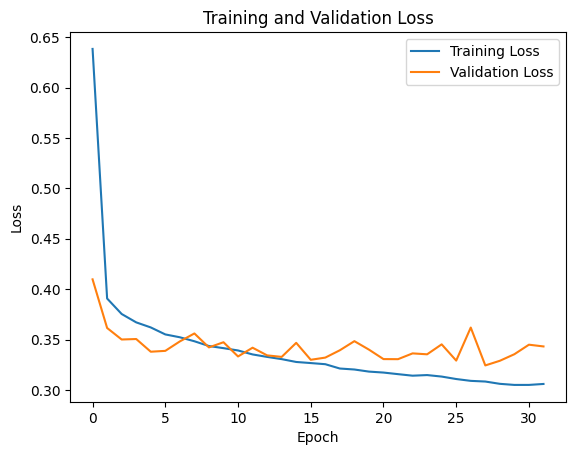

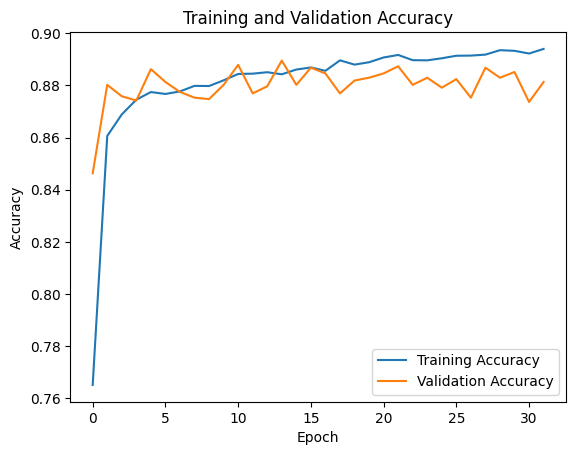

In [29]:
# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

143/143 [==============================] - 0s 1ms/step - loss: 0.3732 - accuracy: 0.8735
Test Accuracy: 0.8734952807426453
Test Loss: 0.3731597363948822


In [1]:
# model.predict()
encoded_df_test.head()

NameError: name 'encoded_df_test' is not defined